In [1]:
import tensorflow as tf

def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [2]:
select_gpu(2)
sequence_length = 128
epochs = 19
model_name = 'bert-chinese'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [3]:
import re

def txt_to_list(path, sequence_length):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
#         text_list = [i for i in text]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
#                 print(entity)            
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
        
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
#             while len(sentence) < sequence_length:
#                 sentence += 'O'
#             if len(sentence) > sequence_length:
#                 sentence = sentence[:sequence_length]
            x.append([i for i in sentence])
            
        tmp = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
#                 while len(tmp) < sequence_length:
#                     tmp.append('O')
#                 if len(tmp) > sequence_length:
#                     tmp = tmp[:sequence_length]
                y.append(tmp)
                tmp = list()
            else:
                tmp.append(i)
        y.append(label_list)
    return [x, y]

In [4]:
x1, y1 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt', sequence_length)

In [5]:
x2, y2 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt', sequence_length)

In [6]:
x4, y4 = txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt', sequence_length)

In [7]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76508
76508


In [8]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48964 48964
12242 12242
15302 15302


In [9]:
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
embed_path = '/home/Danny/pretrain_model/{}'.format(model_name)
bert_embed = BertEmbedding(embed_path, sequence_length=sequence_length)
model = BiLSTM_CRF_Model(bert_embed)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=256,
                   )

2020-12-03 16:06:21,613 [DEBUG] kashgari - ------------------------------------------------
2020-12-03 16:06:21,614 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-03 16:06:21,614 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-03 16:06:21,615 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-03 16:06:21,615 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-03 16:06:21,615 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/19
191/191 [==============================] - 126s 658ms/step - loss: 0.7733 - accuracy: 0.9651 - val_loss: 26.5126 - val_accuracy: 0.9853
Epoch 2/19
191/191 [==============================] - 122s 637ms/step - loss: 0.2260 - accuracy: 0.9860 - val_loss: 26.2812 - val_accuracy: 0.9879
Epoch 3/19
191/191 [==============================] - 122s 638ms/step - loss: 0.1743 - accuracy: 0.9882 - val_loss: 26.0379 - val_accuracy: 0.9893
Epoch 4/19
191/191 [==============================] - 122s 638ms/step - loss: 0.1427 - accuracy: 0.9897 - val_loss: 25.8232 - val_accuracy: 0.9867
Epoch 5/19
191/191 [==============================] - 122s 637ms/step - loss: 0.1229 - accuracy: 0.9908 - val_loss: 25.6243 - val_accuracy: 0.9867
Epoch 6/19
191/191 [==============================] - 122s 637ms/step - loss: 0.1069 - accuracy: 0.9915 - val_loss: 25.4066 - val_accuracy: 0.9872
Epoch 7/19
191/191 [==============================] - 121s 634ms/step - loss: 0.0899 - accuracy: 0.9926 - val_loss: 25

In [10]:
model.evaluate(test_x, test_y)
model_path = 'model/{}-epoch-{}'.format(model_name, epochs)
model.save(model_path)

2020-12-03 16:45:35,265 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 72
2020-12-03 16:45:35,361 [DEBUG] kashgari - predict seq_length: None, input: (2, 15302, 72)


479/479 [==============================] - 261s 546ms/step


2020-12-03 16:50:01,093 [DEBUG] kashgari - predict output: (15302, 72)
2020-12-03 16:50:01,094 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.8217    0.8314    0.8265       848
       contact     0.8750    0.5385    0.6667        13
         money     0.6875    0.8462    0.7586        52
          name     0.9326    0.8300    0.8783       100
      med_exam     0.8108    0.8571    0.8333       140
      location     0.9011    0.9011    0.9011        91
        family     1.0000    0.5294    0.6923        17
    profession     1.0000    0.4444    0.6154         9
            ID     1.0000    0.6250    0.7692         8
  organization     0.0000    0.0000    0.0000         3
     education     0.0000    0.0000    0.0000         1
clinical_event     1.0000    0.2500    0.4000         4

     micro avg     0.8301    0.8243    0.8272      1286
     macro avg     0.8326    0.8243    0.8247      1286



2020-12-03 16:50:10,021 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-19


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese-epoch-19'

In [11]:
from matplotlib import pyplot as plt

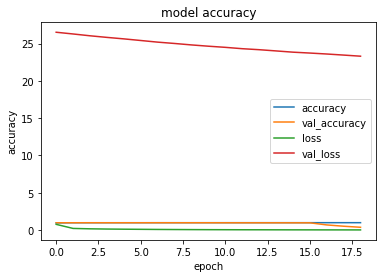

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [13]:
import pandas as pd
df = pd.read_csv('/home/Danny/AI-CUP-2020/datasets/stage4/development_2.csv')
df

,Unnamed: 0,article_id,text
0,0,0,醫師：這個要電腦看才有辦法，這是嚴重或一般的。民眾：這是沒關係啦。醫師：沒關係齁。民眾：他一...
1,1,1,醫師：就照舊這樣子。阿這一定要跟你講一下。家屬：沒關係啊。醫師：阿最近好嗎？民眾：都正常。醫...
2,2,2,醫師：就照這樣，我們就照這樣問診這樣而已啦，阿最近我們8月17號有抽血。家屬：對上上個禮拜。...
3,3,3,醫師：最近有怎麼樣嗎？民眾：都一樣欸。醫師：會痛還是怎麼樣嗎？民眾：都一樣。醫師：有發燒或是...
4,4,4,民眾：前一次是6月14號。醫師：嗯，14。民眾：13還是14。醫師：我看一下14啊，13和1...
...,...,...,...
65,65,65,個管師：來坐這裡。民眾：好，坐這裡嗎？好，靠你那麼近？個管師：靠我近一點好啊，不好嗎？會讓你...
66,66,66,個管師：好喘……哈哈哈哈。民眾：哈哈。個管師：好。小明這個月還好嗎？民眾：很好啊。個管師：很...
67,67,67,個管師：所以你是去篩檢的時候……民眾：恩。個管師：你去篩檢的時候然後許小姐跟你說你可以來這邊...
68,68,68,個管師：好喔，過去這一個月還好嗎？民眾：恩，還可以。個管師：那今天是請假？民眾：沒有，晚上上...


In [14]:
def predict_NER(model, text, sequence_length):
    x_list = list()
    while len(text) > sequence_length:
        x_list.append([i for i in text[:sequence_length]])
        text = text[sequence_length:]        
    x_list.append([i for i in text[:sequence_length]])
    y_list = model.predict(x_list)
    merge_list = list()
    for i in y_list:
        for j in i:
            merge_list.append(j)
    return merge_list

In [15]:
def output_NER(article_id, text, y):
    output = str()
    flag = False
    for i, j in enumerate(y):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            output += '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
    return output

In [16]:
output="article_id\tstart_position\tend_position\tentity_text\tentity_type\n"
for article_id, text in zip(df['article_id'], df['text']):
    y = predict_NER(model, text, sequence_length)
    output += output_NER(article_id, text, y)

2020-12-03 16:50:10,428 [DEBUG] kashgari - predict seq_length: None, input: (2, 27, 130)


1/1 [==============================] - 0s 2ms/step


2020-12-03 16:50:14,306 [DEBUG] kashgari - predict output: (27, 130)
2020-12-03 16:50:14,306 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0 10  7 ...  1  1  0]
 ...
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 16:50:14,308 [DEBUG] kashgari - predict seq_length: None, input: (2, 7, 130)


1/1 [==============================] - 0s 747us/step


2020-12-03 16:50:15,089 [DEBUG] kashgari - predict output: (7, 130)
2020-12-03 16:50:15,091 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1 10  7  7  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 855us/step


2020-12-03 16:50:15,881 [DEBUG] kashgari - predict output: (12, 130)
2020-12-03 16:50:15,881 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:15,883 [DEBUG] kashgari - predict seq_length: None, input: (2, 26, 130)


1/1 [==============================] - 0s 941us/step


2020-12-03 16:50:16,729 [DEBUG] kashgari - predict output: (26, 130)
2020-12-03 16:50:16,729 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 4 1 0]
 [0 6 4 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:16,731 [DEBUG] kashgari - predict seq_length: None, input: (2, 17, 130)


1/1 [==============================] - 0s 759us/step


2020-12-03 16:50:17,546 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 16:50:17,547 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:17,549 [DEBUG] kashgari - predict seq_length: None, input: (2, 23, 130)


1/1 [==============================] - 0s 844us/step


2020-12-03 16:50:18,371 [DEBUG] kashgari - predict output: (23, 130)
2020-12-03 16:50:18,372 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:18,373 [DEBUG] kashgari - predict seq_length: None, input: (2, 13, 130)


1/1 [==============================] - 0s 807us/step


2020-12-03 16:50:19,172 [DEBUG] kashgari - predict output: (13, 130)
2020-12-03 16:50:19,172 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:19,174 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


1/1 [==============================] - 0s 932us/step


2020-12-03 16:50:19,952 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 16:50:19,953 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:19,954 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 2ms/step


2020-12-03 16:50:20,731 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 16:50:20,731 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 8 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:20,732 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 821us/step


2020-12-03 16:50:21,512 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 16:50:21,514 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  6  4  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  1  1  1  1  1  1  1  6
   4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 877us/step


2020-12-03 16:50:22,284 [DEBUG] kashgari - predict output: (5, 130)
2020-12-03 16:50:22,286 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  10  7  1  1  1  1  1 10  7  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1
   6  4  4  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4
   4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 1ms/step


2020-12-03 16:50:23,099 [DEBUG] kashgari - predict output: (19, 130)
2020-12-03 16:50:23,100 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:23,102 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 906us/step


2020-12-03 16:50:23,879 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 16:50:23,880 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:23,881 [DEBUG] kashgari - predict seq_length: None, input: (2, 10, 130)


1/1 [==============================] - 0s 963us/step


2020-12-03 16:50:24,669 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 16:50:24,669 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 10  7  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 16:50:24,670 [DEBUG] kashgari - predict seq_length: None, input: (2, 11, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 16:50:25,464 [DEBUG] kashgari - predict output: (11, 130)
2020-12-03 16:50:25,465 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 4 4 4]]
2020-12-03 16:50:25,467 [DEBUG] kashgari - predict seq_length: None, input: (2, 16, 130)


1/1 [==============================] - 0s 836us/step


2020-12-03 16:50:26,279 [DEBUG] kashgari - predict output: (16, 130)
2020-12-03 16:50:26,279 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:26,280 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 16:50:27,045 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 16:50:27,047 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1
   1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 829us/step


2020-12-03 16:50:27,886 [DEBUG] kashgari - predict output: (25, 130)
2020-12-03 16:50:27,887 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:27,888 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 16:50:28,651 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 16:50:28,653 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4
   4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1 10  7  7  1  1  1  1  1  1  

2/2 [==============================] - 1s 400ms/step


2020-12-03 16:50:30,324 [DEBUG] kashgari - predict output: (48, 130)
2020-12-03 16:50:30,324 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:30,327 [DEBUG] kashgari - predict seq_length: None, input: (2, 37, 130)


2/2 [==============================] - 1s 376ms/step


2020-12-03 16:50:31,957 [DEBUG] kashgari - predict output: (37, 130)
2020-12-03 16:50:31,958 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:31,960 [DEBUG] kashgari - predict seq_length: None, input: (2, 28, 130)


1/1 [==============================] - 0s 969us/step


2020-12-03 16:50:32,811 [DEBUG] kashgari - predict output: (28, 130)
2020-12-03 16:50:32,811 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:32,813 [DEBUG] kashgari - predict seq_length: None, input: (2, 31, 130)


1/1 [==============================] - 0s 816us/step


2020-12-03 16:50:33,673 [DEBUG] kashgari - predict output: (31, 130)
2020-12-03 16:50:33,674 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:33,676 [DEBUG] kashgari - predict seq_length: None, input: (2, 15, 130)


1/1 [==============================] - 0s 973us/step


2020-12-03 16:50:34,467 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 16:50:34,468 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:34,469 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


1/1 [==============================] - 0s 708us/step


2020-12-03 16:50:35,258 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 16:50:35,259 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:35,260 [DEBUG] kashgari - predict seq_length: None, input: (2, 10, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 16:50:36,038 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 16:50:36,038 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:36,040 [DEBUG] kashgari - predict seq_length: None, input: (2, 21, 130)


1/1 [==============================] - 0s 822us/step


2020-12-03 16:50:36,866 [DEBUG] kashgari - predict output: (21, 130)
2020-12-03 16:50:36,867 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:36,868 [DEBUG] kashgari - predict seq_length: None, input: (2, 5, 130)


1/1 [==============================] - 0s 986us/step


2020-12-03 16:50:37,625 [DEBUG] kashgari - predict output: (5, 130)
2020-12-03 16:50:37,627 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1 12  9  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1 12  9  1  1  1  1  1  1  1  1  1  1  1  1  1 12  9  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1 12  9  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 902us/step


2020-12-03 16:50:38,454 [DEBUG] kashgari - predict output: (21, 130)
2020-12-03 16:50:38,455 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:38,456 [DEBUG] kashgari - predict seq_length: None, input: (2, 21, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 16:50:39,278 [DEBUG] kashgari - predict output: (21, 130)
2020-12-03 16:50:39,279 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 6 4 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:39,280 [DEBUG] kashgari - predict seq_length: None, input: (2, 14, 130)


1/1 [==============================] - 0s 832us/step


2020-12-03 16:50:40,079 [DEBUG] kashgari - predict output: (14, 130)
2020-12-03 16:50:40,080 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 6 4 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:40,082 [DEBUG] kashgari - predict seq_length: None, input: (2, 17, 130)


1/1 [==============================] - 0s 910us/step


2020-12-03 16:50:40,908 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 16:50:40,908 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 4 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:40,910 [DEBUG] kashgari - predict seq_length: None, input: (2, 23, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 16:50:41,724 [DEBUG] kashgari - predict output: (23, 130)
2020-12-03 16:50:41,725 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:41,726 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 679us/step


2020-12-03 16:50:42,523 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 16:50:42,524 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:42,526 [DEBUG] kashgari - predict seq_length: None, input: (2, 37, 130)


2/2 [==============================] - 1s 374ms/step


2020-12-03 16:50:44,148 [DEBUG] kashgari - predict output: (37, 130)
2020-12-03 16:50:44,148 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:44,151 [DEBUG] kashgari - predict seq_length: None, input: (2, 40, 130)


2/2 [==============================] - 1s 379ms/step


2020-12-03 16:50:45,789 [DEBUG] kashgari - predict output: (40, 130)
2020-12-03 16:50:45,789 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ... 11  1  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 16:50:45,791 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 904us/step


2020-12-03 16:50:46,568 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 16:50:46,569 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:46,570 [DEBUG] kashgari - predict seq_length: None, input: (2, 12, 130)


1/1 [==============================] - 0s 835us/step


2020-12-03 16:50:47,365 [DEBUG] kashgari - predict output: (12, 130)
2020-12-03 16:50:47,366 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:47,367 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 16:50:48,137 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 16:50:48,139 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 12
   9  1  1  1  1  1  1  1  1  1  1  1  1 12  9  1  1  1  1  1  1 12  9  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  6  4  1  6  4  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  6  4  4  4  1  1  1  1  1  1  1  1  1  1  1
   1  1 12  9  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 924us/step


2020-12-03 16:50:48,956 [DEBUG] kashgari - predict output: (18, 130)
2020-12-03 16:50:48,957 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:48,958 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


1/1 [==============================] - 0s 785us/step


2020-12-03 16:50:49,746 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 16:50:49,747 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:49,748 [DEBUG] kashgari - predict seq_length: None, input: (2, 16, 130)


1/1 [==============================] - 0s 795us/step


2020-12-03 16:50:50,551 [DEBUG] kashgari - predict output: (16, 130)
2020-12-03 16:50:50,552 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:50,554 [DEBUG] kashgari - predict seq_length: None, input: (2, 24, 130)


1/1 [==============================] - 0s 834us/step


2020-12-03 16:50:51,407 [DEBUG] kashgari - predict output: (24, 130)
2020-12-03 16:50:51,408 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:51,409 [DEBUG] kashgari - predict seq_length: None, input: (2, 13, 130)


1/1 [==============================] - 0s 854us/step


2020-12-03 16:50:52,190 [DEBUG] kashgari - predict output: (13, 130)
2020-12-03 16:50:52,190 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:52,191 [DEBUG] kashgari - predict seq_length: None, input: (2, 15, 130)


1/1 [==============================] - 0s 915us/step


2020-12-03 16:50:52,994 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 16:50:52,995 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  0]
 ...
 [ 0  1  1 ... 12  9  0]
 [ 0  1  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]]
2020-12-03 16:50:52,997 [DEBUG] kashgari - predict seq_length: None, input: (2, 10, 130)


1/1 [==============================] - 0s 804us/step


2020-12-03 16:50:53,781 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 16:50:53,782 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 6 ... 1 1 1]]
2020-12-03 16:50:53,785 [DEBUG] kashgari - predict seq_length: None, input: (2, 43, 130)


2/2 [==============================] - 1s 392ms/step


2020-12-03 16:50:55,441 [DEBUG] kashgari - predict output: (43, 130)
2020-12-03 16:50:55,442 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 4 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:55,444 [DEBUG] kashgari - predict seq_length: None, input: (2, 19, 130)


1/1 [==============================] - 0s 903us/step


2020-12-03 16:50:56,257 [DEBUG] kashgari - predict output: (19, 130)
2020-12-03 16:50:56,258 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:56,259 [DEBUG] kashgari - predict seq_length: None, input: (2, 16, 130)


1/1 [==============================] - 0s 684us/step


2020-12-03 16:50:57,069 [DEBUG] kashgari - predict output: (16, 130)
2020-12-03 16:50:57,069 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:57,073 [DEBUG] kashgari - predict seq_length: None, input: (2, 38, 130)


2/2 [==============================] - 1s 383ms/step


2020-12-03 16:50:58,704 [DEBUG] kashgari - predict output: (38, 130)
2020-12-03 16:50:58,704 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 6 4 0]
 [0 6 4 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 6 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:50:58,707 [DEBUG] kashgari - predict seq_length: None, input: (2, 32, 130)


1/1 [==============================] - 0s 989us/step


2020-12-03 16:51:01,908 [DEBUG] kashgari - predict output: (32, 130)
2020-12-03 16:51:01,910 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 0]
 [0 1 6 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:01,915 [DEBUG] kashgari - predict seq_length: None, input: (2, 48, 130)


2/2 [==============================] - 1s 397ms/step


2020-12-03 16:51:03,578 [DEBUG] kashgari - predict output: (48, 130)
2020-12-03 16:51:03,578 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:03,580 [DEBUG] kashgari - predict seq_length: None, input: (2, 14, 130)


1/1 [==============================] - 0s 816us/step


2020-12-03 16:51:04,383 [DEBUG] kashgari - predict output: (14, 130)
2020-12-03 16:51:04,383 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:04,385 [DEBUG] kashgari - predict seq_length: None, input: (2, 9, 130)


1/1 [==============================] - 0s 963us/step


2020-12-03 16:51:05,167 [DEBUG] kashgari - predict output: (9, 130)
2020-12-03 16:51:05,167 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:05,168 [DEBUG] kashgari - predict seq_length: None, input: (2, 5, 130)


1/1 [==============================] - 0s 2ms/step


2020-12-03 16:51:05,937 [DEBUG] kashgari - predict output: (5, 130)
2020-12-03 16:51:05,939 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1 13  8  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 865us/step


2020-12-03 16:51:06,733 [DEBUG] kashgari - predict output: (11, 130)
2020-12-03 16:51:06,734 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 6 4 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:06,735 [DEBUG] kashgari - predict seq_length: None, input: (2, 19, 130)


1/1 [==============================] - 0s 823us/step


2020-12-03 16:51:07,554 [DEBUG] kashgari - predict output: (19, 130)
2020-12-03 16:51:07,554 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 6 0]
 [0 6 4 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:07,556 [DEBUG] kashgari - predict seq_length: None, input: (2, 17, 130)


1/1 [==============================] - 0s 731us/step


2020-12-03 16:51:08,370 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 16:51:08,371 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:08,373 [DEBUG] kashgari - predict seq_length: None, input: (2, 7, 130)


1/1 [==============================] - 0s 976us/step


2020-12-03 16:51:09,155 [DEBUG] kashgari - predict output: (7, 130)
2020-12-03 16:51:09,157 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1 10  7  7  7  7 13  8  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  4  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  6  4  4  1  1  6  4  4  1  1  1
   1  1  1  1  1  1  6  4  1  6  4  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  

1/1 [==============================] - 0s 859us/step


2020-12-03 16:51:09,971 [DEBUG] kashgari - predict output: (17, 130)
2020-12-03 16:51:09,972 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 9 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:09,974 [DEBUG] kashgari - predict seq_length: None, input: (2, 22, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 16:51:10,793 [DEBUG] kashgari - predict output: (22, 130)
2020-12-03 16:51:10,793 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:10,795 [DEBUG] kashgari - predict seq_length: None, input: (2, 20, 130)


1/1 [==============================] - 0s 1ms/step


2020-12-03 16:51:11,610 [DEBUG] kashgari - predict output: (20, 130)
2020-12-03 16:51:11,611 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:11,612 [DEBUG] kashgari - predict seq_length: None, input: (2, 8, 130)


1/1 [==============================] - 0s 962us/step


2020-12-03 16:51:12,393 [DEBUG] kashgari - predict output: (8, 130)
2020-12-03 16:51:12,394 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:12,395 [DEBUG] kashgari - predict seq_length: None, input: (2, 3, 130)


1/1 [==============================] - 0s 833us/step


2020-12-03 16:51:13,149 [DEBUG] kashgari - predict output: (3, 130)
2020-12-03 16:51:13,150 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 4 4 4 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 4 4 4 1 1 1 1 1 1 6 4 4 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]]
2020-12-03 16:51:13,151 [DEBUG] kashgari - predict seq_len

1/1 [==============================] - 0s 786us/step


2020-12-03 16:51:13,936 [DEBUG] kashgari - predict output: (10, 130)
2020-12-03 16:51:13,936 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:13,938 [DEBUG] kashgari - predict seq_length: None, input: (2, 15, 130)


1/1 [==============================] - 0s 773us/step


2020-12-03 16:51:14,742 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 16:51:14,743 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 6 4 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:14,744 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 728us/step


2020-12-03 16:51:15,501 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 16:51:15,503 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1 13  8  6  4  4  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  6  4  1  0]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  6  4  1  1  1  

1/1 [==============================] - 0s 1ms/step


2020-12-03 16:51:16,304 [DEBUG] kashgari - predict output: (14, 130)
2020-12-03 16:51:16,305 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]
2020-12-03 16:51:16,306 [DEBUG] kashgari - predict seq_length: None, input: (2, 6, 130)


1/1 [==============================] - 0s 742us/step


2020-12-03 16:51:17,081 [DEBUG] kashgari - predict output: (6, 130)
2020-12-03 16:51:17,083 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 1 1 1 1 1 6 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 4 1 1
  1 1 1 1 1 1 1 1 6 4 1 1 1 1 1 1 1 6 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

1/1 [==============================] - 0s 930us/step


2020-12-03 16:51:17,881 [DEBUG] kashgari - predict output: (15, 130)
2020-12-03 16:51:17,882 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]]


In [17]:
print(output)

article_id	start_position	end_position	entity_text	entity_type
0	256	258	25	med_exam
0	273	276	李醫生	name
0	320	322	25	med_exam
0	326	328	25	med_exam
0	400	403	11點	time
0	409	411	4點	time
0	424	427	一小時	time
0	615	619	11點多	time
0	644	647	這兩天	time
0	1168	1172	7月21	time
0	1809	1812	10多	med_exam
0	2200	2203	13號	time
0	2214	2217	15天	time
0	2226	2228	3天	time
0	2259	2263	一個禮拜	time
0	2319	2322	禮拜一	time
0	2332	2335	禮拜一	time
0	2372	2375	前幾天	time
0	2555	2558	皇后區	location
0	2624	2628	下下禮拜	time
0	2735	2740	布魯克林區	location
0	2752	2755	皇后區	location
0	2760	2763	皇后區	location
0	2767	2770	皇后區	location
0	2774	2777	皇后區	location
0	2780	2782	北區	location
0	2807	2810	下禮拜	time
0	2859	2862	1小時	time
0	3029	3031	昨天	time
0	3067	3070	下禮拜	time
0	3340	3343	下禮拜	time
1	59	62	108	med_exam
1	66	69	108	med_exam
1	457	460	五月中	time
1	671	674	三個月	time
2	27	32	8月17號	time
2	40	45	上上個禮拜	time
2	53	56	110	med_exam
2	111	114	6.0	med_exam
2	279	282	2年前	time
2	563	566	光華路	location
2	571	574	光華路	location
2	980	982	兩天	time
2	1114	1116	半年	t

In [18]:
output_path='output/{}-epo-{}.tsv'.format(model_name, epochs)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output)